# Objective
**- To classify the given disease normal pneumonia Tuberculosis universal_test**<br>
**- Multiclass classification problem**<br>

# Dependencies

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

print(tf.__version__)

# Set constants
data_dir = r"data"
batch_size = 32
img_height = 128
img_width = 128

ModuleNotFoundError: No module named 'seaborn'

# Data preprocessing

**- Loading and splitting data<br>**
**- Train:80% and Validation:20%**

In [26]:
# Create training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 19418 files belonging to 5 classes.
Using 15535 files for training.
Found 19418 files belonging to 5 classes.
Using 3883 files for validation.


In [27]:
# Dynamically get class names
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['Covid', 'Normal', 'Pneumonia', 'Tuberculosis', 'lung cancer']


# EDA

In [28]:
# Define a function to plot class distribution
def plot_distribution(y, title):
    class_count = Counter(y)
    y_labels = [class_names[i] for i in range(len(class_names))]
    x_values = [class_count[i] for i in range(len(class_names))]
    
    plt.figure(figsize=(8, 3))
    plt.barh(y_labels, x_values, color='blue')
    plt.title(title)
    plt.xlabel("Number of Images")
    return plt.show()

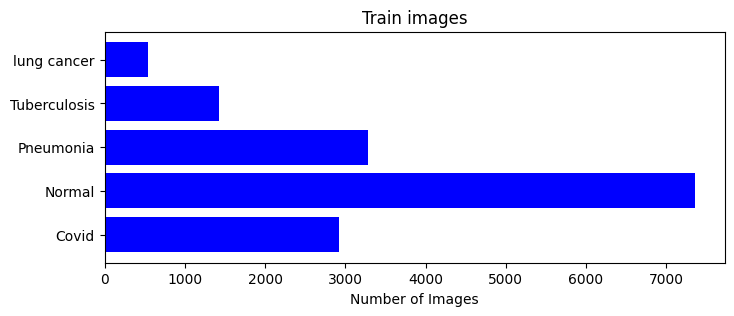

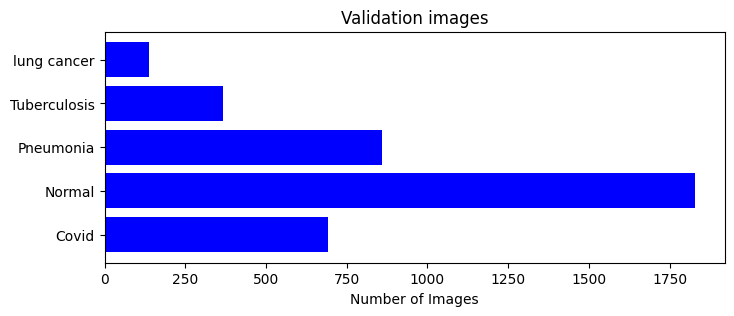

In [29]:
# Flatten labels for the datasets
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

# Plot the distributions
plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title="Validation images")


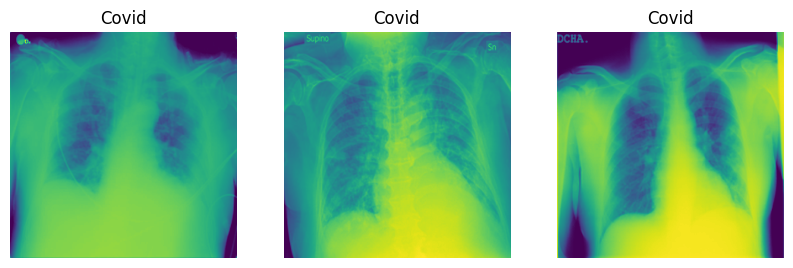

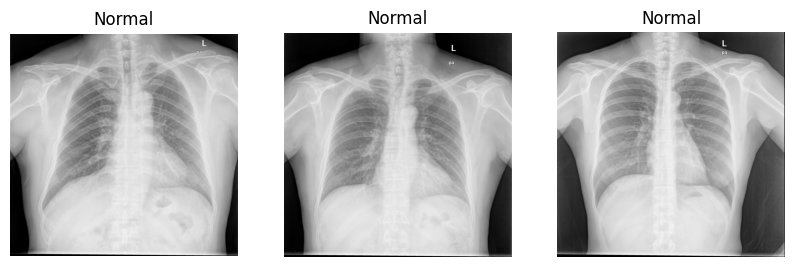

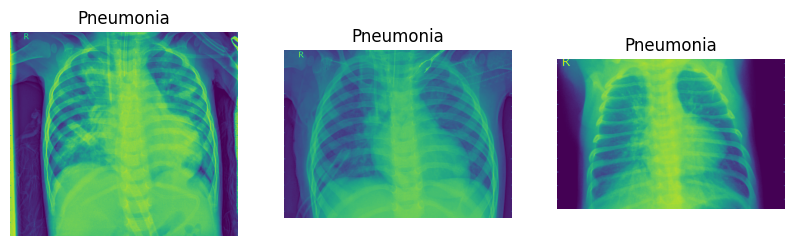

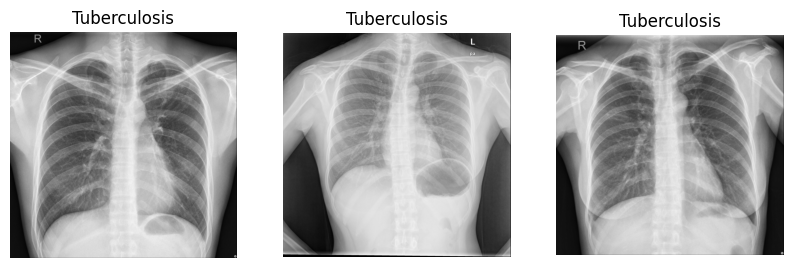

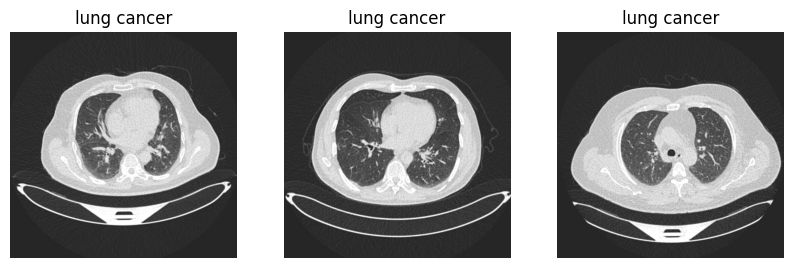

In [31]:
# Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Reshape, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Model architecture - VGG19 and Capsule Neural Network
num_classes = 4

# Load the pre-trained VGG19 model
base_model = tf.keras.applications.VGG19(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of VGG19
base_model.trainable = False

# Capsule Network layer definition
class CapsuleLayer(Layer):
    def __init__(self, num_capsules, dim_capsules, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.num_capsules * self.dim_capsules),
            initializer="glorot_uniform",
            trainable=True,
        )

    def call(self, inputs):
        # Capsule layer implementation
        u_hat = tf.linalg.matmul(inputs, self.kernel)
        u_hat = tf.reshape(u_hat, [-1, self.num_capsules, self.dim_capsules])
        # Routing-by-agreement can be added here if needed
        return tf.keras.activations.softmax(u_hat, axis=1)

# Build the model
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Capsule Layer (example configuration: 10 capsules with 16 dimensions each)
caps_output = CapsuleLayer(num_capsules=num_classes, dim_capsules=16)(x)

# Length layer to compute the probability of each capsule
output = tf.keras.layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1)))(caps_output)

model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 capsule_layer_3 (CapsuleLay  (None, 4, 16)            8192      
 er)                                                             
                                                           

# Model Training

In [32]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    callbacks=[earlystop_callback])

2.12.0
Epoch 1/5
486/486 [==============================] - 713s 1s/step - loss: 0.5594 - accuracy: 0.7959 - val_loss: 0.3325 - val_accuracy: 0.8715
Epoch 2/5
486/486 [==============================] - 644s 1s/step - loss: 0.3906 - accuracy: 0.8487 - val_loss: 0.2897 - val_accuracy: 0.8942
Epoch 3/5
486/486 [==============================] - 662s 1s/step - loss: 0.3273 - accuracy: 0.8743 - val_loss: 0.2742 - val_accuracy: 0.8929
Epoch 4/5
486/486 [==============================] - 654s 1s/step - loss: 0.3052 - accuracy: 0.8833 - val_loss: 0.2771 - val_accuracy: 0.8980
Epoch 5/5
486/486 [==============================] - 680s 1s/step - loss: 0.2881 - accuracy: 0.8929 - val_loss: 0.2564 - val_accuracy: 0.9034


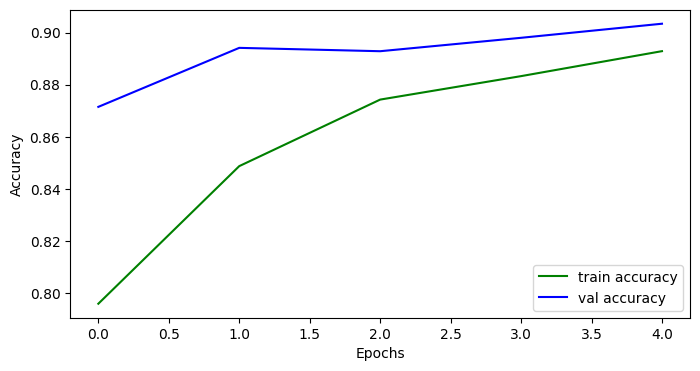

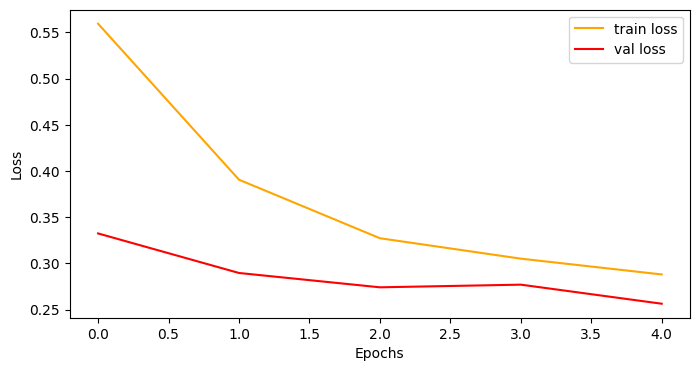

122/122 [==============================] - 129s 1s/step - loss: 0.2564 - accuracy: 0.9034
Validation accuracy: 0.9
Validation loss: 0.26
1/1 [==============================] - 2s 2s/step


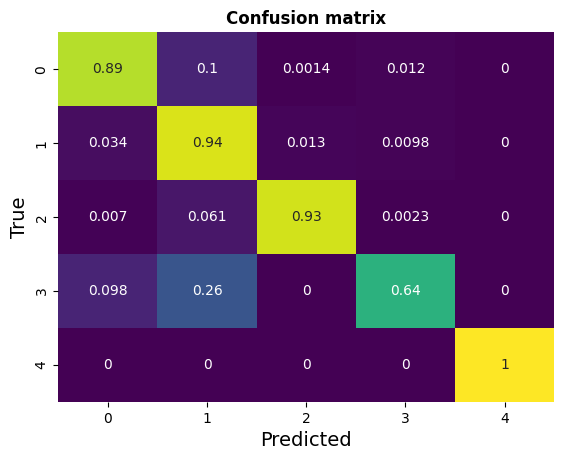

In [33]:

# Plot accuracy and loss
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("Validation accuracy:", round(acc, 2))
print("Validation loss:", round(loss, 2))

# Confusion matrix
y_pred = []  # store predicted labels
y_true = []  # store true labels

# Iterate over the dataset
for image_batch, label_batch in val_ds:
    # Append true labels
    y_true.append(label_batch)
    # Compute predictions
    preds = model.predict(image_batch)
    # Append predicted labels
    y_pred.append(np.argmax(preds, axis=-1))

# Convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [34]:
# Save the model
model.save("capsule_vgg19.h5")

In [36]:
def prediction(img):
    class_names = ['Covid', 'Normal', 'Pneumonia', 'Tuberculosis', 'lung cancer']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',
             edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2,3,4], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

1/1 [==============================] - 0s 79ms/step


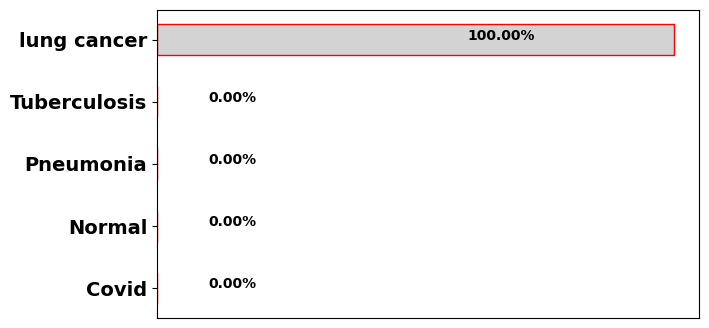

In [37]:
img = r'G:/old projects/covid19-pneumonia-tuberculosis/data/lung cancer/Bengin case (1).jpg'
prediction(img)

In [38]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       693
           1       0.89      0.94      0.91      1829
           2       0.97      0.93      0.95       859
           3       0.89      0.64      0.75       366
           4       1.00      1.00      1.00       136

    accuracy                           0.90      3883
   macro avg       0.92      0.88      0.90      3883
weighted avg       0.90      0.90      0.90      3883

